# Preparations

## Notebook extensions

In [1]:
%%javascript
require(['base/js/utils'],
function(utils) {
    utils.load_extensions('IPython-notebook-extensions-3.x/usability/comment-uncomment');
    utils.load_extensions('IPython-notebook-extensions-3.x/usability/dragdrop/main');
});

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2

## Imports and configuration

We set the path to the config.cfg file using the environment variable 'JCMPYTHON_CONFIG_FILE'.

In [3]:
import os
os.environ['JCMPYTHON_CONFIG_FILE'] = '/hmi/kme/workspace/scattering_generalized/160719_start/config.cfg'

Now we can import `jcmpython` and `numpy`. Since the parent directory, which contains the jcmpython module, is not automatically in our path, we need to append it before.

In [4]:
import sys
sys.path.append('..')
import jcmpython as jpy
import numpy as np

[INFO] init: This is jcmpython. Starting up.
[INFO] init: Writing logs to file: /hmi/kme/workspace/scattering_generalized/160719_start/examples/logs/160802.log


On import, we receive a some information on the configured logging and JCMsuite version, if the logging level is appropriate. We can get additional info on the version and the license.

In [5]:
jpy.jcm_license_info()

[INFO] init: 
[INFO] init: JCMwave(R) FEM-Solver , Version 3.0.9-release
[INFO] init: Modules: Electromagnetics ElectromagneticsTimeDependent ContinuumMechanics HeatConduction
[INFO] init: Buildtag: linux64-2016.06.24.09.46
[INFO] init: 
[INFO] init: *** license status ***
[INFO] init: 
[INFO] init:   JCMROOT: /hmi/kme/programs/JCMsuite_3_0_9
[INFO] init:   Host: nanosippe03
[INFO] init:   License File: /hmi/kme/programs/JCMsuite_3_0_9/license/license.ljcm
[INFO] init:   Server: nanosippe03
[INFO] init:   HW-Adapter: F8-B1-56-D8-95-11
[INFO] init:   Licensed OS: LINUX
[INFO] init:   License period: 2015-06-08 -> 2016-12-31 
[INFO] init:   Number of licenses: 12
[INFO] init: 


The versions of JCMsuite and jcmpython can be accessed by the module attributes `__jcm_version__` and `__version__`

In [6]:
print 'Version of JCMsuite:', jpy.__jcm_version__
print 'Version of jcmpython:', jpy.__version__

Version of JCMsuite: 3.0.9
Version of jcmpython: 2.0.0


## Extensions

You can get a list of available extensions to jcmpython using the `extensions` module attribute.

In [7]:
jpy.extensions

['materials']

Extensions may have additional dependencies or may need data that is not shipped with jcmpython. You can load an extension using the `load_extension` function.

In [8]:
jpy.load_extension('materials')

[INFO] init: Loaded extension: materials


# Simulation

## Preparing and configuring the simulation set

We start by creating a `JCMProject`-instance describing the project we'd like to run.  The `mie2D`-project is located in a subdirectory of our *project catalog*, which is configured in the section `Data` under key `projects` in the configuration file. We could also specify an absolute path instead. Since we want to leave the actual project untouched, we specify a `working_dir` into which the project is copied before. `JCMgeo` and the template conversion will be executed in the working directory, for example. If we do not specify a working_dir, a folder called `current_run` will be used in the current directory.

In [9]:
wdir = os.path.abspath('working_dir')
project = jpy.JCMProject('scattering/mie/mie2D', working_dir=wdir)

The JCMProject-instance automatically detected the name of the project file:

In [10]:
project.project_file_name

'mie2D.jcmp'

If it fails to find a proper file or if it finds multiple project files, it raises an Exception. You can specify the project file name manually using the parameter `project_file_name` on initialization.

To run simulations using this project, we create a `SimulationSet` (this could also be single simulation). The keys that are necessary to translate the JCM template files (i.e. the `.jcmp(t)`-files) need to be given as a nested `dict` with keys `constants`, `parameters` and `geometry` in the top level. The values for these keys need to be `dict`s as well, providing all necessary keys for the template translation in total. Their function is as follows:

  - `constants`: can be of any type, but are not stored in the HDF5 store. This is useful for minor parameters, such as the info level in the project, as it does not change the result of the simulation. But it can also be used to pass complicated data, such as material data maps.
  - `parameters`: All parameters that *do not* change the geometry, i.e. do not belong to the `layout.jcmt` template.
  - `geometry`: All parameters that *do* change the geometry, i.e. belong to the `layout.jcmt` template.
  
If a sequence is provided for any of the `parameters` or `geometry` values, loops will be performed (depending on the `combination_mode` of the `SimulationSet`).

In the mie2D project, there is only one parameter: the *radius* of the circle. This parameter changes the geometry! We'd like to scan over different radii and, consequently, provide a numpy.array for it. We leave the other two `dict`s empty.

In [11]:
mie_keys = {'constants' :{},
            'parameters': {},
            'geometry': {'radius':np.linspace(0.3, 0.5, 40)}}

Now, the `SimulationSet` can be initialized.

In [12]:
simuset = jpy.SimulationSet(project, mie_keys)

[INFO] jcmpython.core: Using folder /net/group/kme-data/simulations/scattering_generalized/160719_start/examples/160802 for data storage.


We are now informed about the directory in which our data is stored as configured in the configuration file and by the `duplicate_path_levels` parameter. The path is also stored in the attribute `storage_dir`. It now contains an `.h5` database file:

In [13]:
os.listdir(simuset.storage_dir)

['result_database.h5']

We can now make a schedule for the simulations that we want to perform. This includes that

  1. all parameter combinations are determinded,
  2. the simulations are sorted in a way to have minimal calls of JCMgeo (which can be expensive) and
  3. the database is checked for matching simulations which already have been done.

In our case, the database is still empty and we should end up with 40 simulations, as we specified 40 different radii.

In [14]:
simuset.make_simulation_schedule()

[INFO] jcmpython.core: Loops will be done over the following parameter(s): ['radius']
[INFO] jcmpython.core: Total number of simulations: 40


The store should still be empty at this time:

In [15]:
simuset.is_store_empty()

True

Depending on the configured servers, there might be multiple workstations or queues which can be used by the JCMdaemon to run the simulations. For this 2D project, we can restrict the resources to be only the local computer, i.e. 'localhost'.

In [16]:
simuset.use_only_resources('localhost')
simuset.get_current_resources()[0].set_m_n(6,1)

[INFO] jcmpython.core: Restricting resources to: ['localhost']


You can get a list of the currently configured resources that will be used by the SimulationSet using the `get_current_resources`-method.

In [17]:
simuset.get_current_resources()

[Workstation(localhost, M=6, N=1)]

## Computing geometries only

Computing a geometry (i.e. running `jcm.geo`) for a specific simulation of our `SimulationSet` is an easy task now. We only need to call the `compute_geometry` method with the index of the simulation (or the `Simulation` instance itself). We can pass additional keyword arguments to jcm.geo, such as a `jcmt_pattern` if desired.

Let's compute the geometry for the first simulation of our set. The simulation has the following properties:

In [18]:
sim = simuset.simulations[0]
print sim
print 'keys:', sim.keys

Simulation(number=0, status=Pending)
keys: {'radius': 0.29999999999999999}


Now we run jcm.geo for it (we also could have written `simuset.compute_geometry(0)`)

In [19]:
simuset.compute_geometry(0)

The project's working directory now contains a grid file:

In [20]:
os.listdir(simuset.get_project_wdir())

['layout.jcmt',
 'layout.jcmt~',
 'sources.jcm',
 'triangulator.jcm',
 'grid.jcm',
 'materials.jcm',
 'mie2D.jcmp',
 'layout.jcm']

## Running a single simulation

Before demonstrating how to solve the complete set of simulations, we show how to solve a single simulation using JCMsolve. This can be very useful if the simulation is still being developed or if something needs to be recomputed later. We can solve a specific simulation using the `solve_single_simulation` method by passing the simulation number or the Simulation-instance. It automatically computes the geometry (if `compute_geometry` is True) and adds the resources if necessary.

In [21]:
print 'Status before solving:', sim.status
results, logs = simuset.solve_single_simulation(sim)
print 'Status after solving:', sim.status

Status before solving: Pending
Status after solving: Finished


All the results and logs are also stored as attributes of the Simulation-instance as `logs`, `error_message`, `exit_code` and `jcm_results`, e.g.

In [22]:
print sim.logs




*** Solving /net/group/kme-data/simulations/scattering_generalized/160719_start/examples/160802/simulation000000/mie2D.jcmp on refinement level 0 ... 

  A priori segments/wavelength (quality = 2.00e-02)
  FEM degree  'one wavelength'  direction X  direction Y
--------------------------------------------------------
           1              5.57        33.68        33.68
           2              2.65         6.99         6.99
           3              1.90         3.57         3.57
           4              1.34         2.11         2.11
           5              1.04         1.47         1.47
           6              0.85         1.11         1.11
           7              0.72         0.88         0.88
           8              0.61         0.73         0.73
           9              0.53         0.62         0.62
          10              0.47         0.54         0.54
  minimum seg/wavelength in grid : 2.75
  maximum seg/wavelength in grid : 37.35

  *** A priori interior dom

The fieldbag file path is also set as an attribute:

In [23]:
sim.fieldbag_file

'/net/group/kme-data/simulations/scattering_generalized/160719_start/examples/160802/simulation000000/mie2D_results/fieldbag.jcm'

## Developing and using an evaluation function

So far we only have solved the simulation by (1) computing the geometry and (2) running JCMsolve. This is fine and it may be that no further step is desired. However, yet nothing is set up to be saved to the HDF5 store, so nothing but the input parameters will appear in it. As a minimal step, we may want to save the computational costs of our simulations. But normally, post processes will be part of your JCM project file and you may want to (3) extract information from them or even derive quantities from them by further processing.

If all you want to do is store the computational cost, this is automatically done by calling the `evaluate_results` method of the Simulation-instance without further input arguments.

In [24]:
sim.evaluate_results()

If the logging-level is set to 'DEBUG', you see the message 'No result evaluation was done.' to inform you that only the computational costs have been read out. The results that will be stored are now described by the (hidden) attribute `_results_dict`:

In [25]:
sim._results_dict

{'AccumulatedCPUTime': 1.377941,
 'AccumulatedTotalTime': 2.0,
 'CpuPerUnknown': 4.4951901465431989e-05,
 'CpuTime': 1.0,
 'CpuTimeAssembling': 0.226996,
 'CpuTimeInnerNodeUpdate': 0.117289,
 'CpuTimeSolve': 0.16007099999999999,
 'FEDegree0_Percentage': 0.0,
 'FEDegree10_Percentage': 0.0,
 'FEDegree1_Percentage': 0.0,
 'FEDegree2_Percentage': 17.025998731769182,
 'FEDegree3_Percentage': 25.649968294229549,
 'FEDegree4_Percentage': 57.32403297400127,
 'FEDegree5_Percentage': 0.0,
 'FEDegree6_Percentage': 0.0,
 'FEDegree7_Percentage': 0.0,
 'FEDegree8_Percentage': 0.0,
 'FEDegree9_Percentage': 0.0,
 'Level': 0,
 'SystemMemory_GB': 0.02393341064453125,
 'TotalMemory_GB': 0.34729766845703119,
 'TotalTime': 2,
 'TotalTimeAssembling': 1.0,
 'TotalTimeInnerNodeUpdate': 0.0,
 'TotalTimeSolve': 0.0,
 'Unknowns': 22246}

The status of the simulation is now updated.

In [26]:
sim.status

'Finished and evaluated'

To execute further evaluations, we can use the `evaluation_func`-argument. From the docs:

    The `evaluation_func` must be a function of a single input argument. 
    A list of all results returned by post processes in JCMsolve are passed
    to this function. It must return a dict with key-value pairs that should
    be saved to the HDF5 store. Consequently, the values must be of types
    that can be stored to HDF5, otherwise Exceptions will occur in the
    saving steps.

In the mie2D-project a `FluxIntegration` is used as a `PostProcess`-section in mie2D.jcmp. It's results will be passed to the `evaluation_func`. As this is the only post process, the length of the list passed to the `evaluation_func` will be 1. We can see the list using

In [27]:
sim.jcm_results[1:]

[{'AbsElectromagneticFieldEnergyFlux': {0: array([  3.28061875e-09])},
  'DomainIdFirst': array([1], dtype=int32),
  'DomainIdSecond': array([1], dtype=int32),
  'ElectromagneticFieldEnergyFlux': {0: array([  3.27837317e-09 -1.14159218e-11j])},
  'title': 'ElectromagneticFieldEnergyFlux'}]

We'd like to store the real part of the `ElectromagneticFieldEnergyFlux` of the zeroth source, as this is the scattering cross section (SCS) of our Mie-scatterer. The function `evaluation_func` will simply look like this:

In [28]:
def read_scs(pp):
    results = {} #must be a dict
    results['SCS'] = pp[0]['ElectromagneticFieldEnergyFlux'][0][0].real
    return results

We can try it out by running `evaluate_results` results again, this time passing our custom function. We need to set `overwrite` to True to force the evaluation to be executed again.

In [29]:
sim.evaluate_results(evaluation_func=read_scs, overwrite=True)

We now have an additional key called 'SCS' in our `_results_dict`. It will be stored in the HDF5 store.

In [30]:
sim._results_dict['SCS']

3.2783731738282799e-09

You can get the complete data of the simulation including input parameters and results as a pandas DataFrame:

In [31]:
sim._get_DataFrame()

,AccumulatedCPUTime,AccumulatedTotalTime,CpuPerUnknown,CpuTime,CpuTimeAssembling,CpuTimeInnerNodeUpdate,CpuTimeSolve,FEDegree0_Percentage,FEDegree10_Percentage,FEDegree1_Percentage,...,Level,SCS,SystemMemory_GB,TotalMemory_GB,TotalTime,TotalTimeAssembling,TotalTimeInnerNodeUpdate,TotalTimeSolve,Unknowns,radius
0,1.377941,2.0,0.000045,1.0,0.226996,0.117289,0.160071,0.0,0.0,0.0,...,0,3.278373e-09,0.023933,0.347298,2,1.0,0.0,0.0,22246,0.3


## Running all simulations

Finally, we can run all our simulations and evaluate them using our custom `evaluation_func`. This is done in parallel using all the resources that we have added. The results will be appended to the HDF5 store.

In [32]:
simuset.run(N=10, evaluation_func=read_scs)

[INFO] jcmpython.core: Starting to solve.
[INFO] jcmpython.core: Waiting for 10 simulation(s) to finish...
[INFO] jcmpython.core: Waiting for 10 simulation(s) to finish...
[INFO] jcmpython.core: Waiting for 10 simulation(s) to finish...
[INFO] jcmpython.core: Waiting for 10 simulation(s) to finish...
[INFO] jcmpython.core: Total time for all simulations: 0:00:20.752710


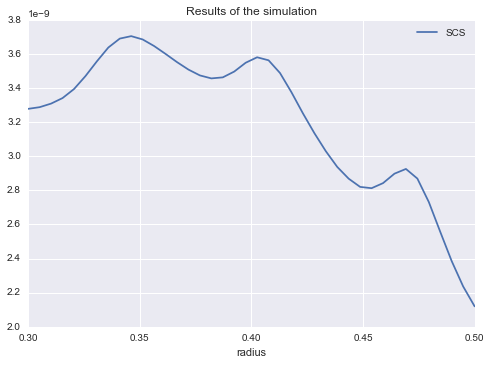

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

data = simuset.get_store_data()
data.plot(x='radius', y='SCS', title='Results of the simulation')

## Adding data in a later run

Let's assume we want to extend our store in a later session. The automatic data comparison will detect that some of the data is already known and will only execute the missing simulations. The same mechanism helps to continue the SimulationSet on the point were it stopped, e.g. due to a keyboard interruption or a server error. 

For demonstration, we extend our list of radii and reinitialize the SimulationSet. To show the power of the comparison mechanism we provide the radii in a mixed up order.

In [34]:
extended_radii = np.append(np.linspace(0.5, 0.6, 40)[1:], np.linspace(0.3, 0.5, 40))
mie_keys_extended = {'constants' :{},
                     'parameters': {},
                     'geometry': {'radius':extended_radii}}

We close the store, delete the SimulationSet instance and start all over.

In [35]:
simuset.close_store()
del simuset

In [36]:
simuset = jpy.SimulationSet(project, mie_keys_extended)
simuset.make_simulation_schedule()

[INFO] jcmpython.core: Using folder /net/group/kme-data/simulations/scattering_generalized/160719_start/examples/160802 for data storage.
[INFO] jcmpython.core: Loops will be done over the following parameter(s): ['radius']
[INFO] jcmpython.core: Total number of simulations: 79
[INFO] jcmpython.core: Found matches in the extended check of the HDF5 store. Number of stored simulations: 40


We are now informed that matches have been found in the HDF5 store. The residual simulations can be executed as before. This time, we set `delete_wdirs` to `True` to demonstarte the automatic deletion of the working directories. 

In [37]:
simuset.run(N=10, evaluation_func=read_scs, delete_wdirs=True)

[INFO] jcmpython.core: Starting to solve.
[INFO] jcmpython.core: Waiting for 10 simulation(s) to finish...
[INFO] jcmpython.core: Waiting for 10 simulation(s) to finish...
[INFO] jcmpython.core: Waiting for 10 simulation(s) to finish...
[INFO] jcmpython.core: Cleaning up old working directories.
[INFO] jcmpython.core: Total time for all simulations: 0:00:24.457117


In [38]:
simuset._wdirs_to_clean

['/net/group/kme-data/simulations/scattering_generalized/160719_start/examples/160802/simulation000067',
 '/net/group/kme-data/simulations/scattering_generalized/160719_start/examples/160802/simulation000068',
 '/net/group/kme-data/simulations/scattering_generalized/160719_start/examples/160802/simulation000047',
 '/net/group/kme-data/simulations/scattering_generalized/160719_start/examples/160802/simulation000048',
 '/net/group/kme-data/simulations/scattering_generalized/160719_start/examples/160802/simulation000043',
 '/net/group/kme-data/simulations/scattering_generalized/160719_start/examples/160802/simulation000044',
 '/net/group/kme-data/simulations/scattering_generalized/160719_start/examples/160802/simulation000045',
 '/net/group/kme-data/simulations/scattering_generalized/160719_start/examples/160802/simulation000046',
 '/net/group/kme-data/simulations/scattering_generalized/160719_start/examples/160802/simulation000039',
 '/net/group/kme-data/simulations/scattering_generalize

We can now plot our extended results.

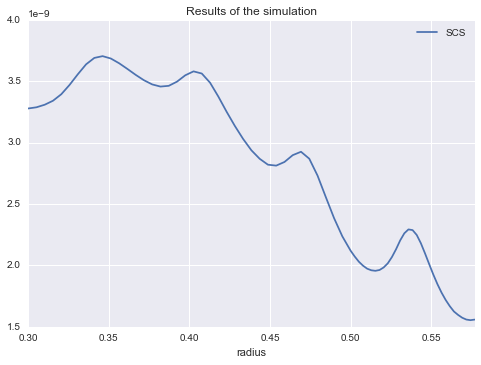

In [39]:
simuset.get_store_data().plot(x='radius', y='SCS', title='Results of the simulation')